# Crystals

---

Crystalline solids have multiple peculiarities connected with their fundamental property: discrete translational symmetry. Additionally, they exhibit additional symmetries which influence their properties (e.g. electronic band structure) as well as procedures used in the calculation. Dealing with crystals require use of Periodic Boundary Conditions and, often, reciprocal space, Brillouin Zone etc. ASE provides multiple tools for working with crystals. We will use some of them in the following examples - which is modeled after one of the AbInit tutorials.

In the following exercise we will:
* build a crystal of Silicon,
* calculate its lattice parameters,
* derive its electronic band structure.

As usual the detailed technical documentation regarding ASE toolbox can be found [ASE documentation site](https://wiki.fysik.dtu.dk/ase/index.html). The documentation concerning the DFT tool used in the exercise is located at [AbInit documentation site](https://docs.abinit.org/).

In [1]:
%pylab inline
from ase.build import bulk
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.calculators.abinit import Abinit
import ase.io
from ase import units as un
import os

# Patch bug in ASE AbInit interface
import ase_patch
ase.io.abinit.read_abinit_out = ase_patch.read_abinit_out

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Building the Silicon crystal

The silicon has a simple crystal structure with two atoms per primitive unit cell - in fact it is the same structure as diamond. Thus, building the structure is almost trivial - the only free parameter is the length of the lattice vector $a$.

In [2]:
Si = bulk('Si', crystalstructure='diamond', a=5.4)
print(Si.cell.cellpar())

[ 3.81837662  3.81837662  3.81837662 60.         60.         60.        ]


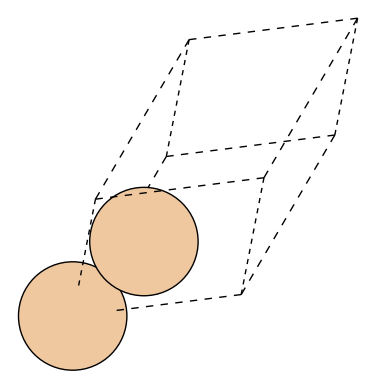

In [3]:
ax = plot_atoms(Si, rotation='10x,20y,15z')
ax.set_axis_off()

In [4]:
calc = Abinit(directory="work_04",
              ecut= 270,
              xc='PBE',
              pps='hgh',
              toldfe=1.0e-6,
              diemac=12,
              nstep=20,
              kptopt=1,
              ngkpt=[2,2,2],
              nshiftk=4,
              shiftk=[[0.5, 0.5, 0.5],
                      [0.5, 0.0, 0.0],
                      [0.0, 0.5, 0.0],
                      [0.0, 0.0, 0.5]]
              )

Si.calc = calc
print('Energy: ', Si.get_potential_energy())
print('Stress tensor:\n', Si.get_stress(voigt=False)/un.GPa)

Energy:  -216.001048427314
Stress tensor:
 [[1.83981555 0.         0.        ]
 [0.         1.83981555 0.        ]
 [0.         0.         1.83981555]]


### Convergence

We will be scanning multiple parameters in our study. To avoid repeating the same code over and over again, we will write (somewhat) universal scanning function. This function uses some more advanced Python techniques like doc-strings inside the function, basic functional programming (`lambda` expression defining anonymous function and function assignment) and passing arguments as dictionaries. You can read about these topics in the python documentation. You can experiment with this function and use it as a basis for your own tools.

To avoid cluttering the examples, all auxiliary functions are collected in one file: `abilib.py` which we import here and in other notebooks. The relevant functions are printed below.

In [5]:
from abilib import set_params, scan_param

In [6]:
?? set_params

Signature:  set_params(calc, **args)
Source:   
def set_params(calc, **args):
    '''
    Create new calculator with modified parameters based on the `calc` argument.
    '''
    params = dict(calc.parameters)
    for k, v in args.items():
        params[k] = v
    return Abinit(directory=calc.directory, **params)
File:      ~/Project/abinitio-methods/abilib.py
Type:      function

In [7]:
?? scan_param

Signature:
 scan_param(
    cryst,
    param,
    start=0,
    stop=1,
    steps=7,
    lista=None,
    log_scale=True,
    int_par=False,
)
Source:   
def scan_param(cryst, param, start=0, stop=1, steps=7, 
               lista=None, log_scale=True, int_par=False):
    '''
    Scan a range of parameter param and plot 
    '''
    fi = lambda x: x
    fo = lambda x: x

    if lista is None:
        if log_scale :
            fi = np.log
            fo = np.exp
        lst = np.linspace(fi(start), fi(stop), steps)
    else :
        int_par=False
        lst = lista
    
    dat = []
    vs = []

    for v in lst:
        print(f'{param}=', end='')
        if lista is None:
            print(f'{int(fo(v)):<8d}' if int_par else f'{fo(v):<8.2f}', end=': ')
        else:
            print(f'{fo(v)}', end=': ')
        if int_par:
            cryst.calc = set_params(cryst.calc, **{param: int(fo(v))})
        else :
            cryst.calc = set_params(cryst.calc, **{param: fo(v)})
        vs

### Energy cutoff convergence

The energy cut-off should be the first parameter to check for convergence. It has a strong influence on both: calculation efficiency and accuracy. It should be selected at the level which provides stable, converged energy differences (not absolute energy) and forces/stresses.

In [8]:
ecuts, eres = scan_param(Si, 'ecut', 250, 500)

ecut=250.00  : -215.933 eV ;  2.410 GPa
ecut=280.62  : -216.026 eV ;  1.606 GPa
ecut=314.98  : -216.102 eV ;  1.005 GPa
ecut=353.55  : -216.148 eV ;  0.578 GPa
ecut=396.85  : -216.172 eV ;  0.346 GPa
ecut=445.45  : -216.185 eV ;  0.235 GPa
ecut=500.00  : -216.192 eV ;  0.187 GPa


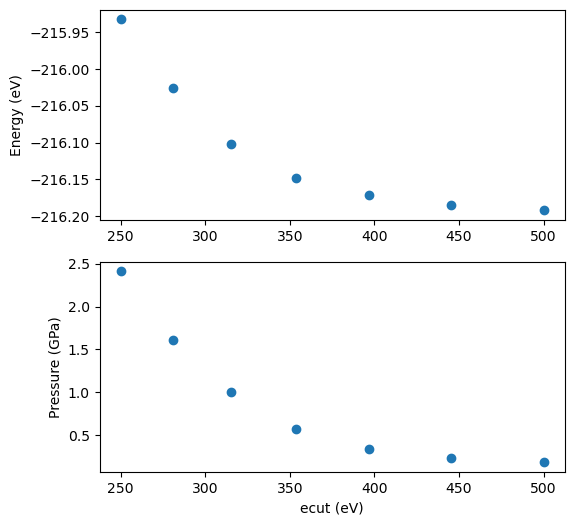

In [9]:
figsize(6,6)
subplot(211)
plot(ecuts, eres[0], 'o')
ylabel('Energy (eV)')
subplot(212)
plot(ecuts, eres[1]/un.GPa, 'o')
ylabel('Pressure (GPa)')
xlabel('ecut (eV)');

Now we set the cutoff at the selected level for future calculations.

In [10]:
Si.calc = set_params(Si.calc, ecut = 350)

### Reciprocal space sampling grid

The grid over which the momentum space integrations are executed plays the similar role to energy cutoff for momenta. It determines how accurate the summations over reciprocal space will be. For insulators and semiconductors, the sparse grid of just few points usually suffices. Sometimes just a single point at zone-center or off-center is enough. For metals, where Fermi surface enters the Brillouin zone, it needs to be much denser. Since this is a discrete parameter, we provide a list of grid sizes to the scanning function.

In [21]:
kv, kres = scan_param(Si, 'ngkpt', lista=[[1,1,1], [2,2,2], [3,3,3], [4,4,4], [5,5,5]])

ngkpt=[1, 1, 1]: -211.779 eV ; -6.245 GPa
ngkpt=[2, 2, 2]: -214.031 eV ; -0.333 GPa
ngkpt=[3, 3, 3]: -214.159 eV ; -0.024 GPa
ngkpt=[4, 4, 4]: -214.172 eV ; -0.001 GPa
ngkpt=[5, 5, 5]: -214.173 eV ; -0.003 GPa


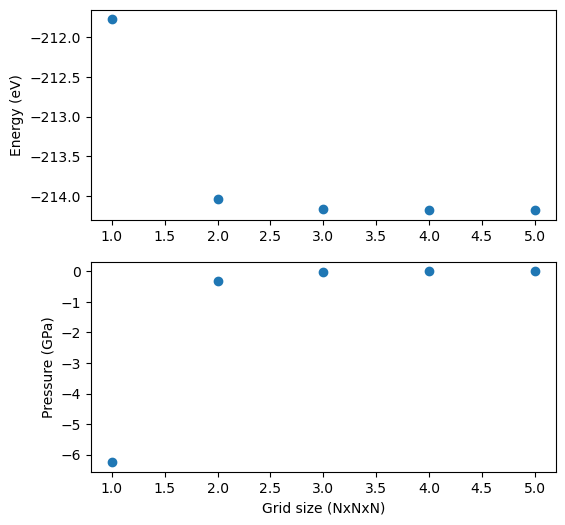

In [22]:
subplot(211)
plot([k[0] for k in kv], kres[0], 'o')
ylabel('Energy (eV)')
subplot(212)
plot([k[0] for k in kv], kres[1]/un.GPa, 'o')
ylabel('Pressure (GPa)')
xlabel('Grid size (NxNxN)');

Now we fix both parameters for future calculations. In real production calculations, the energy convergence should be checked at this point, to make sure that the resulting calculation is indeed well converged.

In [23]:
ngp=4
Si.calc = set_params(Si.calc, ecut=350, ngkpt=[ngp, ngp, ngp])

### Cell size optimization

To find optimum size of the cell we run the calculator with `optcell=1` parameter (plus some other connected parameters). After the run is finished we read-in the results and update the crystal.

In [24]:
print('Initial cell:\n  ', Si.cell.cellpar())
print('Initial stress:\n  ', Si.get_stress()/un.GPa, 'GPa')

Initial cell:
   [ 3.84627441  3.84627441  3.84627441 60.         60.         60.        ]
Initial stress:
   [-0.00080608 -0.00080608 -0.00080608  0.          0.          0.        ] GPa


In [25]:
# Set up the calculation
Si.calc = set_params(Si.calc, 
                     optcell=1,              # Optimize cell volume
                     ionmov=2,               # Update atomic positions
                     ntime=20,               # Max. number of steps
                     ecutsm=0.5*un.Ha,       # Energy buffer for changing basis
                     chkdilatmx=0,
                    )

# Run the calculation and check the result
print(Si.get_potential_energy(), Si.get_stress()[:3]/un.GPa)

-214.171809130701 [-0.00080608 -0.00080608 -0.00080608]


Update the crystal from the `Si.calc.results` dictionary and check if we have acceptable convergence by switching off optimization mode (`optcell=0`) and recalculating the stress tensor.

In [26]:
# Update the cell matrix
Si.set_cell(Si.calc.results['atoms'].cell, scale_atoms=True)

# Reset the calculator to the *single point* mode
Si.calc = set_params(Si.calc, optcell=0, ionmov=0)

In [27]:
print('Final cell:\n  ', Si.cell.cellpar())
print('Final stress:\n  ', Si.get_stress()/un.GPa, 'GPa')

Final cell:
   [ 3.84627443  3.84627443  3.84627443 60.         60.         60.        ]
Final stress:
   [-0.00080502 -0.00080502 -0.00080502  0.          0.          0.        ] GPa


In [28]:
print(f'Final lattice constant a = {2*Si.cell[0,2]:.4f} A')

Final lattice constant a = 5.4395 A
